# Performance Evaluation of ArmorVox
ArmorVox is a voice biometric engine by Auraya System Ltd that has been used on speaker recognition solutions. 
This project aim to evaluate speaker recognition performance of ArmorVox. 
Different treatments will be perform on the enrolment and verificaiton uttrances, we will evaluate the engine based on the false rejection and false acceptance rate.


# Problem of Interest
In this project, we are interested to find out:
- Do channels affect the performance in enrolment and verification?
- What this affect the False Rejection Rate ?

# Data Preparation

## Speaker Audio
The speech data used come from austalk, a database of speech audio recorded between 2011 and 2016. The data is available in Alveo (http://alveo.edu.au/). 100 speakers are selected from the database. Each speaker read a story ( https://bigasc.edu.au/media/attachments/AusTalk-Protocol-Story.pdf ).Each paragaph is recorded as an audio with a total of 8 parts (coded: 3_001,3_002,3_003,3_004,3_005,3_006,3_007,3_008).

Each recording has 6 recoding channels. We used CH6-speaker and Ch2-Boundary to produce uttrances in our experiment, due to the quality of audio. Ch6-speaker is recorded by a headset on the speakers and Ch2-Boundary(which is a meeting micophone sat on the table.

## White Noise
We would like to know if a continuous noise affect the performance of the engine so one of our treatments is combining the uttrances to different loudness of white noise. White noise is a level and continous random noise signal. It was generated based on normal distribution N(0,P), where P is the average power of the recording by the speaker.


## Impulse
Although most of the audio are recorded with minimal noise, we simulated evironment noise with by convolving the audio with impulse signal. 

The impulse data used to similate the environment noise in the toilet come from rirusyd, a colleciton created by Doheon Lee and Densil Cabrera (Doheon Lee, Densil Cabrera
, Effect of listening level and background noise on the subjective decay rate of room impulse responses: Using time-varying loudness to model reverberance, Applied Acoustics, Volume 71, Issue 9, September 2010, Pages 801-811, ISSN 0003-682X, http://dx.doi.org/10.1016/j.apacoust.2010.04.005. (http://www.sciencedirect.com/science/article/pii/S0003682X10000861)).

In this project, we simulated the speaker recoginition environment as close as possilbe. Toilet is a 'quiet' closed room that people can easily access. It is likely to be use for performing any speaker recognition activity. So we have chosen toilet-58deg.wav which produce an echo signal to the uttrances.


## Background Noise

An audio of dog barking is selected from freesound.(https://freesound.org/people/InspectorJ/sounds/406085/).

Compare to white noise, the background noise we are using (dog barking) represent a discrete high power noise signal. We would like to test how the structure of the noise (continuous/discrete) affect the performance of the engine. 


# The Experiment Set-up

*Text Independent* mode is used. Voice print that is created that is independent to the text the speakers read during enrolment. So the speakers do not need to read the same content to be verfied. 

In our experiment, three audios is combined to create an minute enrolment uttrance for each speaker. Another two audios are then used for calcutating the optimal threshold score for each experiment. The rest will be used to test how many observation are falling below the threshold to calculate the false rejection and false acceptance rate. 


The audio will be modify with one of the following treatment:
1. Clean
2. Added white noise with signal to noise ratio 5, 10 or 20
3. Convolve with the toilet impulse
4. Added dog barking as background noise with signal to noise ratio$^*$ 5,10 or20

\* Signal to noise ratio of background noise is calculated based on averaging the power of the noise.


In this project, for each channels we have run through two set of experiment:
1. Clean enrolment uttrances with modified verification uttrances
2. Modified enrolment uttrances with clean enrolment uttrances


# The Experiment Procedure:

1. The audios are resampled and/or added noise to create a uttrance.
2. An enrolment uttrance is created by combining '3_001','3_002','3_003' for each speaker.
3. This enrolment uttrances will then sent to ArmorVox to enrol a voice print. 
4. A enrolment status will then returned by the system and written in to "enrol_experiment.csv".
5. The remaining audios of each speaker will then **cross match** to a list of speakers enrolled and provide a score for how well they matched.



# 1. Control Group (Clean on Enrol, Clean on Verify)

We set Ch6_speaker with clean uttrances for enrolment and verification as our control group. A binary label (0/1) will be put if the speaker. Below is a first few rows of the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os, re,json,pprint
from report_ext import frr_far_cal ,extract_result, result_df, get_enrol_result, read_result
from austalk import mylistdir

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
control = read_result('completed_experiment/experiment11_0.json')

In [3]:
# split the data based on true speaker and imposter
true_speaker = control.loc[control['true_speaker']==1]
imposter = control.loc[control['true_speaker']==0]

# split the data for training and testing
true_speaker_train = true_speaker.loc[(true_speaker['content']=="_3_004") | (true_speaker['content']=="_3_005")]
true_speaker_test = true_speaker.loc[(true_speaker['content']!="_3_004") & (true_speaker['content']!="_3_005")]
imposter_train = imposter.loc[(imposter['content']=="_3_004") | (imposter['content']=="_3_005")]
imposter_test = imposter.loc[(imposter['content']!="_3_004") & (imposter['content']!="_3_005")]

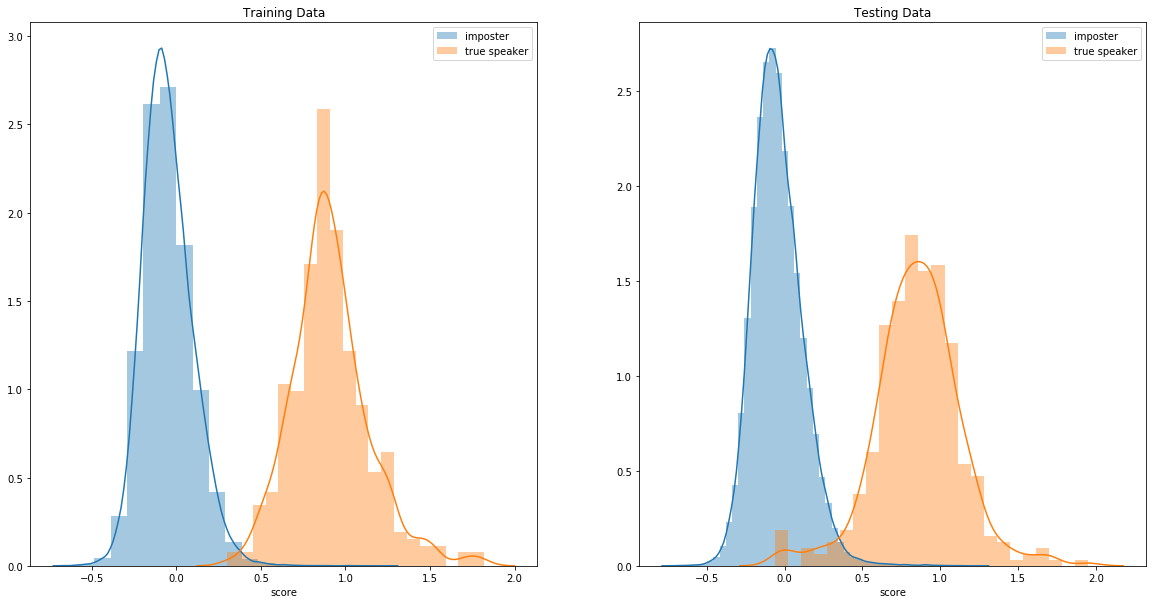

In [4]:
# plot the graph for training and testing data
plt.figure(1,figsize=(20,10))
plt.subplot(121)
sns.distplot(imposter_train['score'], bins=20, label='imposter')
sns.distplot(true_speaker_train['score'],bins=20, label='true speaker')
plt.title('Training Data')
plt.legend()
plt.subplot(122)
sns.distplot(imposter_test.score, label='imposter')
sns.distplot(true_speaker_test.score, label='true speaker')
plt.title('Testing Data')
plt.legend()
plt.show()

We can observed the socre for true speakers and imposters are in two different distributions with true speakers has scores generally higher than imposters. Our interest of this is the overlaping area: the false rejections and false acceptance.

We may also see the variation for true speaker in testing data is slightly wider than the training data. This is due to the sample size of speakers is relatively small.

In [5]:
# show the quantile scores for different data set
quantile = [.001,.01,.05,.1,.5,.9,.99,.999]
pd.DataFrame({
"true_speaker_train":true_speaker_train.score.quantile(quantile),
"true_speaker_test":true_speaker_test.score.quantile(quantile),
"imposter_train":imposter_train.score.quantile(quantile),
"imposter_test":imposter_test.score.quantile(quantile)
})

,imposter_test,imposter_train,true_speaker_test,true_speaker_train
0.001,-0.487000,-0.4900,-0.051437,0.325875
0.010,-0.366000,-0.3560,0.015650,0.449800
0.050,-0.276000,-0.2670,0.419500,0.552000
0.100,-0.230000,-0.2240,0.548500,0.653000
0.500,-0.059200,-0.0645,0.855500,0.885500
0.900,0.161000,0.1450,1.170000,1.225000
0.990,0.386000,0.3450,1.655000,1.607000
0.999,0.775122,0.5900,1.871250,1.799300


## False Reject Rate(FRR) and False Accepatance rate (FAR)

To calculate the false reject rate, we first assume an accpetable false acceptance rate is 1%. 

**False rejection rate = number of false reject cases / total number of true speakers in the data**

The top 1% quantile score of the imposter will be used as the optimal reject threshold of that experiment. Any true speaker uttrances falls **below** the threshold will be consider as false rejected


On the other hand, if we allowed only 1% of the speakers being false rejected.

**False acceptance rate = number of false accept cases / number of imposters in the data**

For false acceptance rate, we will take the optimize the lowest 1% quantile score of true speaker as the optimal threshold. Any imposter uttrances scored **above** the threshold will be consider as false accept.


In [6]:
benchmark_fr = imposter_train.score.quantile(.99,'higher')
false_reject = true_speaker_test[true_speaker_test['score']<benchmark_fr]
false_reject_R = false_reject.shape[0]/true_speaker_test.shape[0]

benchmark_fa = true_speaker_train.score.quantile(.01,'lower')
false_accept = imposter_test[imposter_test['score']>benchmark_fa]
false_accept_R = false_accept.shape[0]/imposter_test.shape[0]

benchmark = [benchmark_fr,benchmark_fa]

print("The FRR threshold score of the control group is: %.2f"%benchmark_fr)
print('Number of true speakers: %.0f'%true_speaker_test.shape[0])
print('THe number of false rejects: %.0f'%false_reject.shape[0])
print("The false rejection rate of the control is: %.4f"%false_reject_R)
print("The FAR threshold score of the control group is: %.2f"%benchmark_fa)
print('Number of imposters: %.0f'%imposter_test.shape[0])
print('THe number of false accepts: %.0f'%false_accept.shape[0])
print("The false accept rate of the control is: %.4f"%false_accept_R)

The FRR threshold score of the control group is: 0.34
Number of true speakers: 376
THe number of false rejects: 15
The false rejection rate of the control is: 0.0399
The FAR threshold score of the control group is: 0.45
Number of imposters: 75314
THe number of false accepts: 478
The false accept rate of the control is: 0.0063


# 2. Clean on Enrol, Treatment on Verify
## Enrolment
In this section, we tested if different channels affect the verification scores. And we first check the enrolment performance for every channel. As seen below, ch1_maptask has a lower mean score and a larger variance. This is due to the recording device is set-up further away from the speakers compare to the other channels.

In [7]:
enrol_ch6 = pd.read_csv('result/enrol/enrol_experiment11_0.csv')
enrol_ch2 = pd.read_csv('result/enrol/enrol_experiment13_0.csv')
enrol = pd.concat([enrol_ch6.groupby('status').count(),enrol_ch2.groupby('status').count()],axis=1)
enrol.columns = ['ch6_speaker','ch2_boundary']
enrol

,ch6_speaker,ch2_boundary
status,,
good,77,129
qafailed,23,69


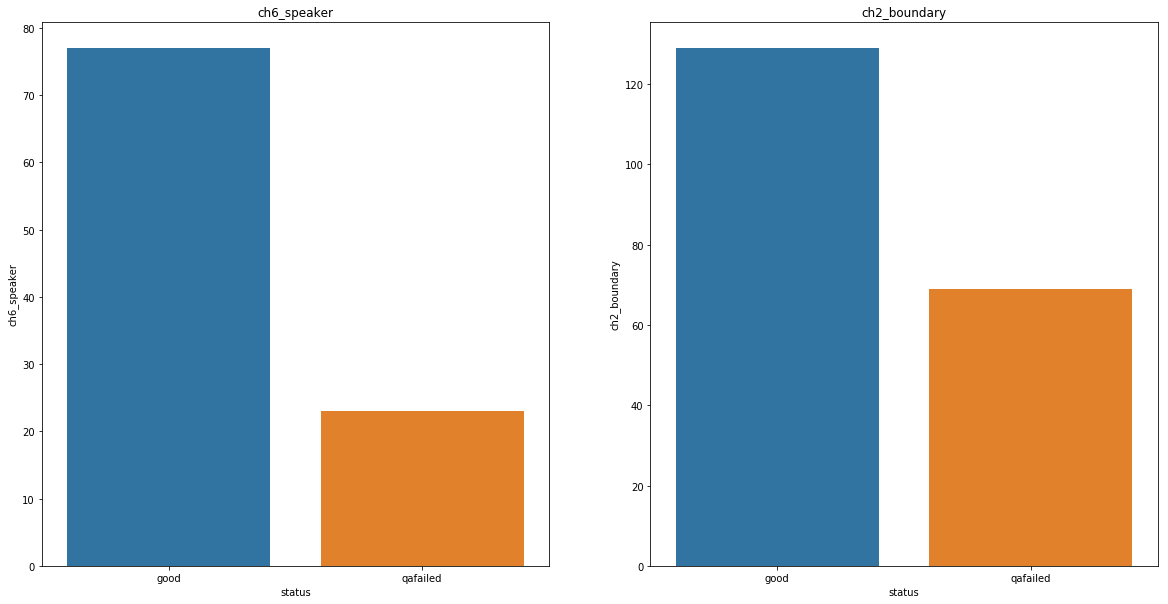

In [8]:
plt.figure(1,figsize=(20,10))
plt.subplot(121)
sns.barplot(x=enrol.index,y=enrol.ch6_speaker)
plt.title('ch6_speaker')
plt.subplot(122)
sns.barplot(x=enrol.index,y=enrol.ch2_boundary)
plt.title('ch2_boundary')
plt.show()

Although the total number of speakers enrolling from the two channels are different, we can still observed that ch6-speakers have a higher proportion of sucessful enrolment than ch2-boundary. More uttrances failed in ch2_boundary becasue there are more noise received by the micophone as it is placed further from the speakers. The micophone also record the signal from different direction which may discount the quality of the uttrances for enrolment.

## Verification

In [9]:
experiment_settings = mylistdir('completed_experiment/')
exp_files = ['experiment11_','experiment13_']
df = extract_result(exp_files,experiment_settings, benchmark)

The following section compare the false rejection rate and false acceptance rate with different treatments.

### False Rejection Rate (FRR)
The number of optimal false rejects (**fr_opt**) is determined based the how many observations falls below the thresold  optimised for each experiment. On the other hand, the number of benchmark false rejects(**fr_b**) is determeined based the number of observations with score below the control group threshold **0.34**. After we calculated the the false rejects, we calculated the optimized false rejection rate(**frr_opt**) and the benchmark false rejection rate (**frr_b**) by dividing the repective false reject by the number of true speakers.


**number of false rejections for different treatment on verification**

In [10]:
pd.pivot_table(df, index= 'verify_treatment',columns = 'channel', values = ['frr_opt','frr_b']).round(3)
    

frr_b                          frr_opt  \
channel          ch2-boundary.wav ch6-speaker.wav ch2-boundary.wav   
verify_treatment                                                     
bg_noise05                  0.132           0.078            0.113   
bg_noise10                  0.116           0.058            0.113   
bg_noise20                  0.101           0.045            0.104   
control                     0.089           0.040            0.099   
convolve                    0.885           0.983            0.673   
white_noise05               0.257           0.483            0.135   
white_noise10               0.119           0.184            0.092   
white_noise20               0.096           0.083            0.096   

                                  
channel          ch6-speaker.wav  
verify_treatment                  
bg_noise05                 0.047  
bg_noise10                 0.039  
bg_noise20                 0.037  
control                    0.040  
convolve                   0.344  
white_noise05              0.105  
white_noise10              0.066  
white_noise20              0.043

**false rejection rate for different treatment on verification**

In [11]:
pd.pivot_table(df, index= 'verify_treatment',columns = 'channel', values = ['frr_opt','frr_b']).round(3)

frr_b                          frr_opt  \
channel          ch2-boundary.wav ch6-speaker.wav ch2-boundary.wav   
verify_treatment                                                     
bg_noise05                  0.132           0.078            0.113   
bg_noise10                  0.116           0.058            0.113   
bg_noise20                  0.101           0.045            0.104   
control                     0.089           0.040            0.099   
convolve                    0.885           0.983            0.673   
white_noise05               0.257           0.483            0.135   
white_noise10               0.119           0.184            0.092   
white_noise20               0.096           0.083            0.096   

                                  
channel          ch6-speaker.wav  
verify_treatment                  
bg_noise05                 0.047  
bg_noise10                 0.039  
bg_noise20                 0.037  
control                    0.040  
convolve                   0.344  
white_noise05              0.105  
white_noise10              0.066  
white_noise20              0.043

We can observe as the signal to noise increase (less noisy), the false rejection rate decreases. We can also observed that convolution has dramatically increase the false rejection rate.

### False Acceptance Rate (FAR)
Similar to FFR, false accpentance rate are determined based either optimised for each experiment(**fa_opt**) or based on the control group threshold(**fa_b**) **0.45**. And we also calculated the optimized false acceptance rate (**far_opt**) and benchmark false acceptance rate(**far_b**)

**number of false accepts for different treatments on verify**

In [13]:
pd.pivot_table(df, index= 'verify_treatment',columns = 'channel',values = ['fa_opt','fa_b']).round(3)

fa_b                           fa_opt  \
channel          ch2-boundary.wav ch6-speaker.wav ch2-boundary.wav   
verify_treatment                                                     
bg_noise05                    107             348              989   
bg_noise10                    132             363              558   
bg_noise20                    220             381              126   
control                       439             478              129   
convolve                        3               0             9583   
white_noise05                  34              66             2358   
white_noise10                  96             150              608   
white_noise20                 204             225              428   

                                  
channel          ch6-speaker.wav  
verify_treatment                  
bg_noise05                   921  
bg_noise10                   649  
bg_noise20                   602  
control                      478  
convolve                   14454  
white_noise05               2835  
white_noise10                895  
white_noise20                511

**false acceptance rate for different treatments on verify**

In [14]:
pd.pivot_table(df, index= 'verify_treatment',columns = 'channel',values = ['far_opt','far_b']).round(3)

far_b                          far_opt  \
channel          ch2-boundary.wav ch6-speaker.wav ch2-boundary.wav   
verify_treatment                                                     
bg_noise05                  0.001           0.000            0.015   
bg_noise10                  0.001           0.000            0.009   
bg_noise20                  0.000           0.000            0.002   
control                     0.000           0.000            0.002   
convolve                    0.005           0.005            0.228   
white_noise05               0.001           0.002            0.039   
white_noise10               0.001           0.001            0.010   
white_noise20               0.000           0.000            0.007   

                                  
channel          ch6-speaker.wav  
verify_treatment                  
bg_noise05                 0.012  
bg_noise10                 0.008  
bg_noise20                 0.008  
control                    0.006  
convolve                   0.248  
white_noise05              0.038  
white_noise10              0.012  
white_noise20              0.007

False accepant rate is very low except for convolve the uttrances with toilet impulse. 

# 3. Treatment on Enrol, Clean on Verify
In this section, we are comparing the false rejection rate different treatments was done on the enrolment uttrances.

## Enrolment

In [15]:
experiment_setting = mylistdir('completed_experiment')
exp_files = ['experiment11_0','experiment12_','experiment13_0','experiment14_']

result = get_enrol_result(experiment_setting,exp_files)

enrol_result = pd.DataFrame({        
'ch6-speaker.wav':result.loc[result.channel=='ch6-speaker.wav'].groupby(['treatment','status']).count()['channel'],
'ch2-boundary.wav':result.loc[result.channel=='ch2-boundary.wav'].groupby(['treatment','status']).count()['channel']
})          
enrol_result

ch2-boundary.wav  ch6-speaker.wav
treatment     status                                     
bg_noise05    good                   129              179
              qafailed                69               19
bg_noise10    good                   128              178
              qafailed                70               20
bg_noise20    good                   129              178
              qafailed                69               20
control       good                   129               77
              qafailed                69               23
convolve      good                     5                5
              qafailed               193              193
white_noise05 good                   145              180
              qafailed                53               18
white_noise10 good                   145              181
              qafailed                53               17
white_noise20 good                   139              181
              qafailed                59               17

Similar to the result in control group, ch6-speakers has more sucessful enrolments than ch2-boundary no matter what treatment is done on the enrolment data.

The experiment also shows that convolution on uttrances has made the enrolment failed. More than 90% of the uttrances are rejected by the system.

## Verification
Appart from convolution which failed all the speakers, the false rejection rate is generally much higher if the modification on uttrances is done on enrolment. 

In [16]:
experiment_settings = mylistdir('completed_experiment/')

exp_files = ['experiment11_0','experiment12_','experiment13_0','experiment14_']
df = extract_result(exp_files,experiment_settings, benchmark)

**Number of False Rejects of different treatment on enrol**

In [17]:
pd.pivot_table(df, index= 'enrol_treatment',columns = 'channel', values = ['fr_opt','fr_b']).round(3)

fr_b                           fr_opt  \
channel         ch2-boundary.wav ch6-speaker.wav ch2-boundary.wav   
enrol_treatment                                                     
bg_noise05                    40              29               36   
bg_noise10                    35              22               35   
bg_noise20                    30              16               32   
control                       27              15               30   
convolve                      11              11               11   
white_noise05                119             263               94   
white_noise10                 53             115               49   
white_noise20                 33              32               33   

                                 
channel         ch6-speaker.wav  
enrol_treatment                  
bg_noise05                   18  
bg_noise10                   15  
bg_noise20                   15  
control                      15  
convolve                     11  
white_noise05                86  
white_noise10                24  
white_noise20                15

**False Rejection Rate of different treatment on enrol**

In [18]:
pd.pivot_table(df, index= 'enrol_treatment',columns = 'channel', values = ['frr_opt','frr_b']).round(3)

frr_b                          frr_opt  \
channel         ch2-boundary.wav ch6-speaker.wav ch2-boundary.wav   
enrol_treatment                                                     
bg_noise05                 0.132           0.074            0.118   
bg_noise10                 0.116           0.057            0.116   
bg_noise20                 0.099           0.041            0.105   
control                    0.089           0.040            0.099   
convolve                   1.000           1.000            1.000   
white_noise05              0.349           0.671            0.276   
white_noise10              0.155           0.291            0.144   
white_noise20              0.101           0.081            0.101   

                                 
channel         ch6-speaker.wav  
enrol_treatment                  
bg_noise05                0.046  
bg_noise10                0.039  
bg_noise20                0.039  
control                   0.040  
convolve                  1.000  
white_noise05             0.219  
white_noise10             0.061  
white_noise20             0.038

Given there were only two speakers sucessfully enroled to the system, the 100% false rejection rate can be ignored.

White noise has a higher impact to the performance when it is done on enrolment than it is done on verification. The false rejection rate has almost doubled.

**Number of False Accepts of different treatment on enrol**

In [19]:
pd.pivot_table(df, index= 'enrol_treatment',columns = 'channel', values = ['fa_opt','fa_b']).round(3)

fa_b                           fa_opt  \
channel         ch2-boundary.wav ch6-speaker.wav ch2-boundary.wav   
enrol_treatment                                                     
bg_noise05                   141             214              359   
bg_noise10                   226             309              362   
bg_noise20                   324             403              176   
control                      439             478              129   
convolve                       0               0             1421   
white_noise05                 97             169            15897   
white_noise10                224             226             2252   
white_noise20                395             320              620   

                                 
channel         ch6-speaker.wav  
enrol_treatment                  
bg_noise05                  555  
bg_noise10                  643  
bg_noise20                  663  
control                     478  
convolve                   1421  
white_noise05             16548  
white_noise10              3593  
white_noise20              1131

**False Acceptance Rate of different treatment on enrol**

In [20]:
pd.pivot_table(df, index= 'enrol_treatment',columns = 'channel', values = ['far_opt','far_b']).round(3)

far_b                          far_opt  \
channel         ch2-boundary.wav ch6-speaker.wav ch2-boundary.wav   
enrol_treatment                                                     
bg_noise05                 0.001           0.000            0.006   
bg_noise10                 0.001           0.000            0.006   
bg_noise20                 0.000           0.000            0.003   
control                    0.000           0.000            0.002   
convolve                   0.005           0.005            0.657   
white_noise05              0.002           0.003            0.235   
white_noise10              0.001           0.001            0.033   
white_noise20              0.001           0.000            0.010   

                                 
channel         ch6-speaker.wav  
enrol_treatment                  
bg_noise05                0.007  
bg_noise10                0.008  
bg_noise20                0.009  
control                   0.006  
convolve                  0.657  
white_noise05             0.212  
white_noise10             0.046  
white_noise20             0.014

The false acceptance rate is too small to be show any significant. However, we can observed the convolution has a bigger impact to the performance compare to other treatment

# Conclusion and furture study
To conclude:
1. Channel has an impact to the enrolment. ch6-speakers has a higher proportion of sucessful enrolment.
2. No matter the treatment is done on enrolment or verification, convolution has an impact on the performance of speaker recoginition.
3. Signal to noise ratio of the uttrances is directly proportion to the false reject rate.
4. The engine is consistence even when white noise or background noise is added to the uttrances.

In this project, there are only 100-200 true speakers in every experiment. This is much smaller than observation of imposter. We can upsample the number of true speakers to observe the differences. We also set either enrolment or verificaition is clean, We did not cover treatment against treatment such as the impact for having background noise in both enrolment and verification.

We have also only used one type of bg_noise, covolve impulse. We can extend the test to more different noise and treatment. To evaluate if the result consitent with different type of noise and impulse.

We also only tested text independent for this project. We can extend testing other speaker recognition technique such diigit prompt or text dependent methods.